In [23]:
import librosa
import numpy as np
from scipy.fftpack import dct
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import wave
import math

def split_wav(input_file, output_prefix, segment_duration):
    # Open the input WAV file
    with wave.open(input_file, 'rb') as wav_file:
        # Get the parameters of the input WAV file
        num_channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        frame_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()

        # Calculate the number of frames per segment based on the provided duration
        segment_frames = int(segment_duration * frame_rate)

        # Calculate the total number of segments needed
        total_segments = math.ceil(num_frames / segment_frames)

        # Iterate over the segments and write each one to a separate WAV file
        for segment in range(total_segments):
            # Calculate the start and end frames for the current segment
            start_frame = segment * segment_frames
            end_frame = min(start_frame + segment_frames, num_frames)

            # Set the output filename for the current segment
            output_file = f"{output_prefix}_{segment + 1}.wav"

            # Open the output WAV file
            with wave.open(output_file, 'wb') as output_wav:
                # Set the output file parameters
                output_wav.setnchannels(num_channels)
                output_wav.setsampwidth(sample_width)
                output_wav.setframerate(frame_rate)

                # Set the position in the input WAV file to the start frame of the current segment
                wav_file.setpos(start_frame)

                # Read the frames for the current segment from the input WAV file
                frames = wav_file.readframes(end_frame - start_frame)

                # Write the frames to the output WAV file
                output_wav.writeframes(frames)

            print(f"Segment {segment + 1}/{total_segments} saved as {output_file}")

            # Example usage: split_wav('input.wav', 'output_segment', 10.0)  # Split into 10-second segments

def load_data(data_dir):
    real_files = [os.path.join(data_dir, "1. Real voice", f) for f in os.listdir(os.path.join(data_dir, "1. Real voice")) if f.endswith(".wav")]
    fake_files = [os.path.join(data_dir, "2. Fake voice", f) for f in os.listdir(os.path.join(data_dir, "2. Fake voice")) if f.endswith(".wav")]

    fake_labels = [0] * len(fake_files)
    real_labels = [1] * len(real_files)

    files = fake_files + real_files
    labels = fake_labels + real_labels

    return files, labels


def preprocessing(audio_file,n_features):
    # Load the audio signal
    y, sr = librosa.load(audio_file, sr=None)

    # Step 1: Pre-emphasis
    pre_emphasis_coeff = 0.97
    y_filt = librosa.effects.preemphasis(y, coef=pre_emphasis_coeff)

    # Step 2: Frame blocking
    frame_length = 0.025  # 25 ms
    hop_length = 0.010    # 10 ms
    frame_length_samples = int(frame_length * sr)
    hop_length_samples = int(hop_length * sr)
    frames = librosa.util.frame(y_filt, frame_length= frame_length_samples, hop_length= hop_length_samples)

    # Step 3: Windowing

    frame_length = len(frames)
    output = frames*np.hamming(frame_length)[:, np.newaxis]
    frames = output

    # Step 4: Fast Fourier Transform (FFT)
    fft_size = 512
    spectrogram = np.abs(np.fft.fft(frames, n=fft_size))

    # Step 5: Mel frequency wrapping
    n_mels = n_features
    mel_spec = librosa.feature.melspectrogram(sr=sr, S=spectrogram, n_mels=n_mels)

    # Step 6: Discrete Cosine Transform (DCT)
    n_mfcc = 12
    mfcc = dct(np.log(mel_spec), type=2, axis=1, norm='ortho')[:, :n_mfcc]

    # Scaled MFCC features
    max_mfcc=np.max(mfcc, axis=1)
    mins, maxs=np.min(max_mfcc), np.max(max_mfcc)
    scaled_mfcc=(max_mfcc-mins)/(maxs-mins)

    return scaled_mfcc

url = r"C:\Users\VIET HOANG - VTS\Desktop\data"
files, labels = load_data(url)

X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)

X_train = [preprocessing(file,68) for file in X_train]
X_test = [preprocessing(file,68) for file in X_test]

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Modelin doğruluğunu değerlendirme
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 100.00%


In [18]:
import matplotlib.pyplot as plt

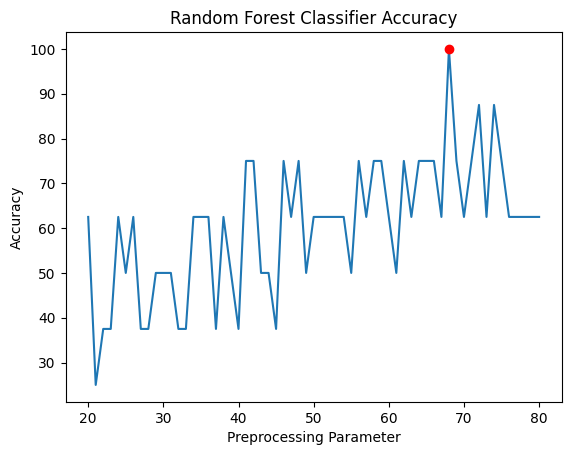

In [19]:
random_class_accuracy_l = []
X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
for i in range(20,81):
    X_train = [preprocessing(file,i) for file in X_train]
    X_test = [preprocessing(file,i) for file in X_test]
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    random_class_accuracy_l.append(accuracy*100)
    X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
# best_accuracy = max(random_class_accuracy_l)
# best_parameter = random_class_accuracy_l.index(best_accuracy) + 20
# plt.plot(range(20, 81), random_class_accuracy_l)
# plt.xlabel('Preprocessing Parameter')
# plt.ylabel('Accuracy')
# plt.title('Random Forest Classifier Accuracy')
# plt.show()

In [24]:
from sklearn import svm
# Create an SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 75.00%


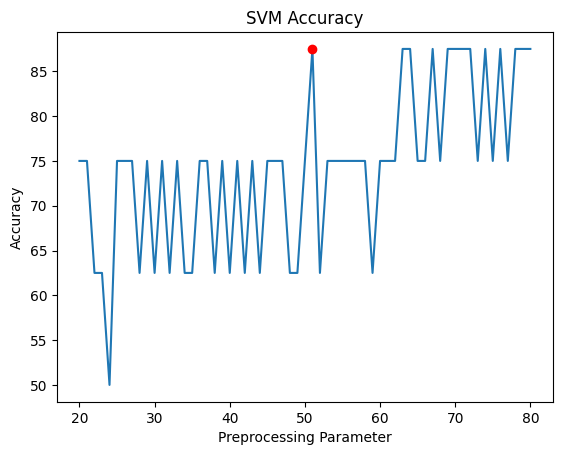

In [30]:
from sklearn import svm
svml = []
X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
for i in range(20,81):
    X_train = [preprocessing(file,i) for file in X_train]
    X_test = [preprocessing(file,i) for file in X_test]
    model = svm.SVC(kernel='linear')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    svml.append(accuracy*100)
    X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
# best_accuracy = max(svml)
# best_parameter = svml.index(best_accuracy) + 20
# plt.plot(range(20, 81), svml)
# plt.plot(best_parameter, best_accuracy, 'ro', label='Best Accuracy')
# plt.xlabel('Preprocessing Parameter')
# plt.ylabel('Accuracy')
# plt.title('SVM Accuracy')
# plt.show()

In [31]:
print(max(svml))

87.5


In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression classifier
clf = LogisticRegression()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

Test Accuracy: 87.50%


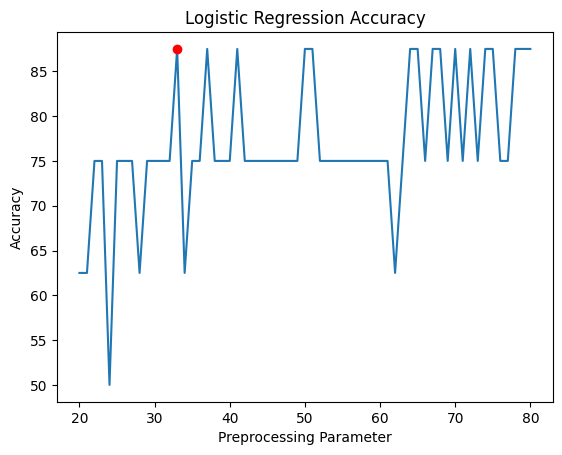

In [33]:
from sklearn.linear_model import LogisticRegression

logistic = []
X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
for i in range(20,81):
    X_train = [preprocessing(file,i) for file in X_train]
    X_test = [preprocessing(file,i) for file in X_test]
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logistic.append(accuracy*100)
    X_train, X_test, y_train, y_test = train_test_split(files, labels, test_size=0.2, random_state=42)
# best_accuracy = max(logistic)
# best_parameter = logistic.index(best_accuracy) + 20
# plt.plot(range(20, 81), logistic)
# plt.plot(best_parameter, best_accuracy, 'ro', label='Best Accuracy')
# plt.xlabel('Preprocessing Parameter')
# plt.ylabel('Accuracy')
# plt.title('Logistic Regression Accuracy')
# plt.show()

In [36]:
print(max(logistic))

87.5


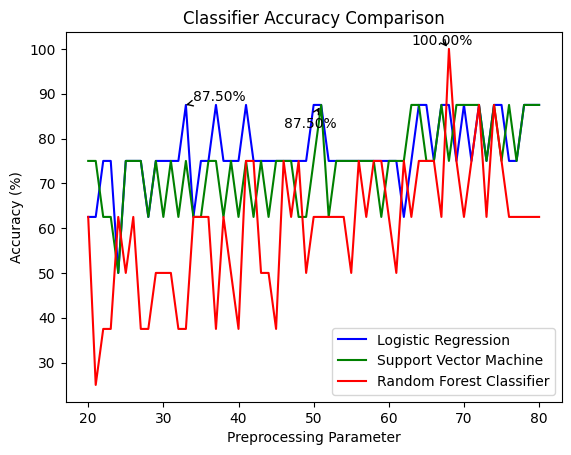

In [42]:
best_accuracy_rf = max(random_class_accuracy_l)
best_parameter_rf = random_class_accuracy_l.index(best_accuracy_rf) + 20

best_accuracy_lr = max(logistic)
best_parameter_lr = logistic.index(best_accuracy_lr) + 20

best_accuracy_svm = max(svml)
best_parameter_svm = svml.index(best_accuracy_svm) + 20

# Plotting the accuracy values
plt.plot(range(20, 81), logistic, label='Logistic Regression', color='blue')
plt.plot(range(20, 81), svml, label='Support Vector Machine', color='green')
plt.plot(range(20, 81), random_class_accuracy_l, label='Random Forest Classifier', color='red')


plt.xlabel('Preprocessing Parameter')
plt.ylabel('Accuracy (%)')
plt.title('Classifier Accuracy Comparison')
plt.legend()

# Add annotations
plt.annotate(f"{best_accuracy_lr:.2f}%", (best_parameter_lr, best_accuracy_lr),
             xytext=(best_parameter_lr + 1, best_accuracy_lr + 1),
             arrowprops=dict(facecolor='blue', arrowstyle='->'))

plt.annotate(f"{best_accuracy_svm:.2f}%", (best_parameter_svm, best_accuracy_svm),
             xytext=(best_parameter_svm - 5, best_accuracy_svm - 5),
             arrowprops=dict(facecolor='green', arrowstyle='->'))

plt.annotate(f"{best_accuracy_rf:.2f}%", (best_parameter_rf, best_accuracy_rf),
             xytext=(best_parameter_rf - 5, best_accuracy_rf + 1),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.show()